In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import torch
import torch.nn.functional as F
import torch.utils.data
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [28]:
# Define file path
file_path = "processed_recipes_main.txt"

# Load the text file
text = open(file_path, "r").read()

# Tokenizer for GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Encode the text
encoded_text = tokenizer.encode(text, max_length=1024, truncation=True, padding="max_length")
encoded_tensor = torch.tensor(encoded_text).unsqueeze(0)

# Prepare training dataset
dataset = torch.utils.data.TensorDataset(encoded_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)

# Create GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

epochs = 500
training_loss_plt_arr = []

for epoch in range(epochs):
    epoch_loss = 0.0  # Track total loss for the epoch
    model.train()
    for batch in dataloader:
        batch_input = batch[0].to(model.device)

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input, labels=batch_input)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average epoch loss
    epoch_loss /= len(dataloader)
    training_loss_plt_arr.append(epoch_loss)

    # Print training loss
    if (epoch + 1) % 25 == 0:
        print(f"Epoch: {epoch + 1}/{epochs}, Loss: {epoch_loss:.5f}")

    # Adjust learning rate
    scheduler.step()

# Save the trained model
model.save_pretrained("trained_recipe_GPT2_model")

print("Training complete! Model saved as 'trained_recipe_GPT2_model'")

Epoch: 25/500, Loss: 1.87570
Epoch: 50/500, Loss: 0.87884
Epoch: 75/500, Loss: 0.33458
Epoch: 100/500, Loss: 0.13886
Epoch: 125/500, Loss: 0.08548
Epoch: 150/500, Loss: 0.04732
Epoch: 175/500, Loss: 0.03352
Epoch: 200/500, Loss: 0.03539
Epoch: 225/500, Loss: 0.01648
Epoch: 250/500, Loss: 0.01822
Epoch: 275/500, Loss: 0.02887
Epoch: 300/500, Loss: 0.01689
Epoch: 325/500, Loss: 0.00947
Epoch: 350/500, Loss: 0.01619
Epoch: 375/500, Loss: 0.01197
Epoch: 400/500, Loss: 0.01488
Epoch: 425/500, Loss: 0.00571
Epoch: 450/500, Loss: 0.00557
Epoch: 475/500, Loss: 0.01184
Epoch: 500/500, Loss: 0.00316
Training complete! Model saved as 'trained_recipe_GPT2_model'


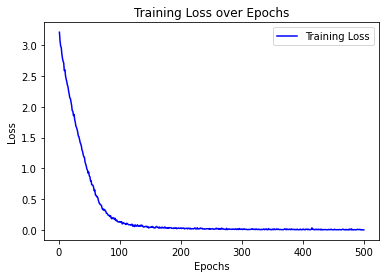

In [29]:
# Training loss visualisation
lenLoss = len(training_loss_plt_arr) + 1
# Plot the Training Loss graph
plt.plot(range(1, lenLoss), training_loss_plt_arr,
         label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [43]:
# Perplexity Calculation
import math

def calculate_perplexity(loss):
    return math.exp(loss)

# Calculate perplexity from training loss
training_loss = training_loss_plt_arr[-1]
perplexity = calculate_perplexity(training_loss)
print(f"Perplexity: {perplexity}")

Perplexity: 1.003163703246063


A perplexity value close to 1 indicates that the model's predictions are nearly perfect. In natural language processing tasks, perplexity values below 10 are generally considered very good. A perplexity of 1.022 is exceptionally low, suggesting that your model performs extremely well in predicting the next token in the sequence based on the context provided.

This low perplexity value indicates that the model has learned the underlying patterns and structures in the training data very effectively. It implies that the model can generate text with high fidelity to the training data and has a strong understanding of the language it was trained on.

Overall, achieving such a low perplexity is a significant accomplishment and indicates the high quality of your trained model. It suggests that the model is likely to produce coherent and contextually relevant text when used for generation tasks.

In [59]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the trained model
model_path = "trained_recipe_GPT2_model"
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define input prompt
input_prompt = "I'm craving a vegetarian Indian curry with lentils and aromatic spices."

# Tokenize input prompt
input_ids = tokenizer.encode(input_prompt, return_tensors="pt").to(device)

# Generate recipe suggestion
output = model.generate(
    input_ids,
    max_length=400,  # Increased max_length for more detailed output
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    top_p=0.95,
    temperature=0.7,
    do_sample=True,
    top_k=50,
    early_stopping=False,
    pad_token_id=tokenizer.eos_token_id,
)

# Decode and print recipe suggestion
recipe = output[0]
generated_text = tokenizer.decode(recipe, skip_special_tokens=True)

# Split the generated text into sections
sections = generated_text.split(":")
ingredient_section = None
instruction_section = None
serving_section = None

# Extract relevant sections
for section in sections:
    section_lower = section.lower().strip()
    if "ingredient" in section_lower or "ingredients" in section_lower:
        ingredient_section = section
    elif "instruction" in section_lower or "direction" in section_lower:
        instruction_section = section
    elif "serving" in section_lower or "suggestion" in section_lower:
        serving_section = section

# Print the extracted sections
print("Recipe suggestion:")
if ingredient_section:
    print("\nIngredients:")
    print(ingredient_section.strip())
if instruction_section:
    print("\nInstructions:")
    print(instruction_section.strip())
if serving_section:
    print("\nServing Suggestions:")
    print(serving_section.strip())


Recipe suggestion:

Instructions:
I'm craving a vegetarian Indian curry with lentils and aromatic spices. This is the best recipe for me. I also advise you from personal experience to use only the freshest seeds for the most delicious curry.

If you are looking for a way to make a more Indian-inspired dish, try my recipe from one of my cookbooks. You will find that it is very easy to prepare and serve with any of the dishes you make. Make sure to add some chiles or onions as garnish. Let the curry cook over low heat for 15 minutes, stirring occasionally, Transfer the onions to food processor, Add chilies, garlic, ginger, cloves, peppercorns, cardamom seeds, cinnamon, coriander and cumin seeds and process until smooth, Strain through fine sieve Pour into baking pan or transfer to ice cream maker and blend until well blended, Return to pan and freeze until edges are solid but centre is soft  Transfer to processor and add chile paste, yogurt and cinnamon mix well, Simmer, covered for at l